In [51]:
suppressPackageStartupMessages({
    library(tidyverse)
    library(ggrepel)
    theme_set(theme_bw())
})

tcg <- read_csv("PTCGP.csv", show_col_types = FALSE) |>
    mutate(Result = if_else(P1 > P2, "Win", "Lose"))
head(tcg)

dim(tcg)


Order,Turns,P1,P2,Damage,Result
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
2,11,2,3,230,Lose
1,14,1,3,80,Lose
2,10,3,0,260,Win
1,15,3,2,270,Win
2,11,0,3,110,Lose
2,9,1,3,170,Lose


[1] 182   6

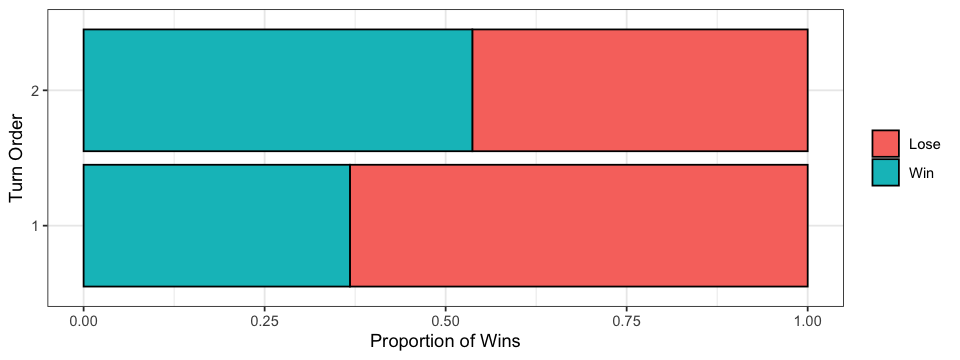

In [63]:
options(repr.plot.width = 8, repr.plot.height = 3)

win_by_order <- tcg |>
    group_by(Order) |>
    summarise(Win_Percentage = mean(Result == "Win"))

ggplot(tcg) +
    aes(x = factor(Order), fill = Result) +
    geom_bar(position = "fill", colour = 1) +
    labs(
        fill = NULL,
        x = "Turn Order",
        y = "Proportion of Wins"
    ) +
    coord_flip()


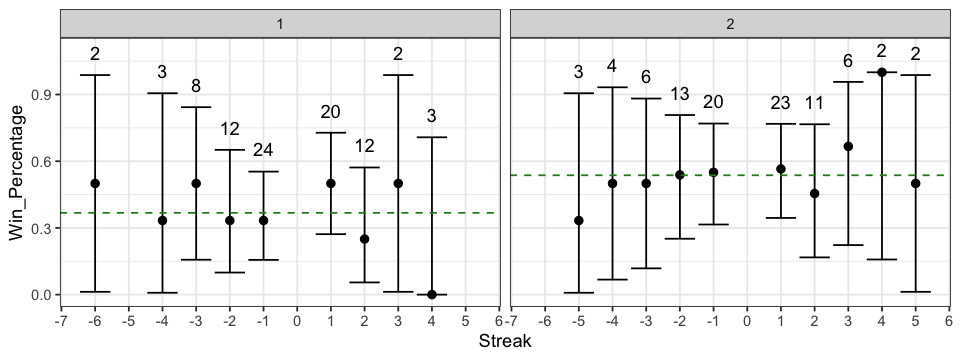

In [ ]:
run_lengths <- rle(tcg$Result)$lengths
run_values <- rle(tcg$Result)$values

streak <- sapply(seq_along(run_lengths), function(x) {
    1:run_lengths[x] * ifelse(run_values[x] == "Win", 1, -1)
}) |> unlist()

tcg$Streak <- c(NA, streak[1:(length(streak) - 1)])
lo <- function(p, n) as.numeric(binom.test(x = round(p * n), n = n)$conf.int)[1]
hi <- function(p, n) as.numeric(binom.test(x = round(p * n), n = n)$conf.int)[2]

tcg |>
    group_by(Streak, Order) |>
    summarise(
        Win_Percentage = mean(Result == "Win"), Games =  n(),
        .groups = "drop"
    ) |>
    rowwise()|> 
    mutate(
        lo = lo(Win_Percentage, Games),
        hi = hi(Win_Percentage, Games)
    ) |>
    filter(Games > 1) |>
    ggplot() +
    aes(x = Streak, y = Win_Percentage) +
    geom_point(aes(colour = Streak > 0), na.rm = TRUE, colour = 1, size = 2) +
    geom_errorbar(aes(ymin = lo, ymax = hi), na.rm = TRUE) +
    geom_text(aes(y = hi, label = Games), na.rm = TRUE, nudge_y = 0.1) +
    theme(legend.position = "none") +
    scale_colour_manual(values = c("firebrick", "forestgreen")) +
    scale_x_continuous(breaks = -10:10, minor_breaks = NULL) +
    facet_wrap(~ Order) +
    geom_hline(
        aes(yintercept = Win_Percentage), data = win_by_order,
        colour = "forestgreen", linetype = "dashed"
    )


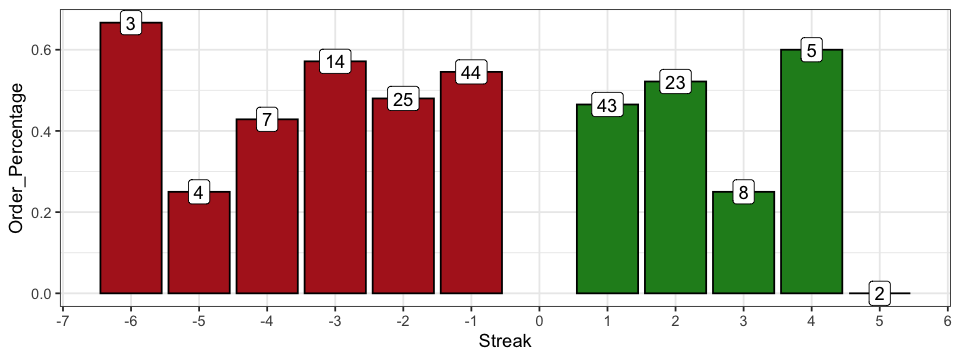

In [ ]:

tcg |>
    group_by(Streak) |>
    summarise(
        Order_Percentage = mean(Order == 1), Games =  n(),
        .groups = "drop"
    ) |>
    filter(Games > 1) |>
    ggplot() +
    aes(x = Streak, y = Order_Percentage) +
    geom_col(aes(fill = Streak > 0), na.rm = TRUE, colour = 1) +
    geom_label(aes(label = Games), na.rm = TRUE) +
    theme(legend.position = "none") +
    scale_fill_manual(values = c("firebrick", "forestgreen")) +
    scale_x_continuous(breaks = -10:10, minor_breaks = NULL)
